# Continuing a region stochastic BOLD simulation

In many cases, it is useful to perform an initial simulation to allow the transient dynamics to dissipate, and then continue the simulation using the steady state obtained from the initial simulation as the initial conditions. The TVB web interface allows for this by 'branching' a loaded simulation. From a Python script, we need to handle the details ourselves. This demo shows how to do that for a region-level, stochastic simulation with the BOLD monitor.

In [11]:
%pylab inline
from tvb.simulator.lab import *
import cPickle

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Initial transient

First, we build and configure the initial simulator,

In [15]:
sim = simulator.Simulator(
    model=models.Generic2dOscillator(), 
    connectivity=connectivity.Connectivity(load_default=True),                      
    coupling=coupling.Linear(a=0.0126),
    simulation_length=1e4,
    integrator=integrators.HeunStochastic(
        dt=2 ** -4,
        noise=noise.Additive(nsig=array([0.001]))),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500.0),
        monitors.ProgressLogger(period=1e3)
    )
).configure()

2016-06-02 11:42:51,962 - INFO - tvb.simulator.models.base - Generic2dOscillator(**kwargs): initing...
2016-06-02 11:42:51,999 - WARNING - tvb.basic.readers - File hemispheres not found in ZIP.
2016-06-02 11:42:52,020 - INFO - tvb.simulator.noise - Additive(ntau, random_stream, nsig): initing...
2016-06-02 11:42:52,022 - INFO - tvb.simulator.integrators - HeunStochastic(dt, clamped_state_variable_indices, clamped_state_variable_values, noise): initing...
2016-06-02 11:42:52,024 - INFO - tvb.simulator.integrators - HeunStochastic(dt, clamped_state_variable_indices, clamped_state_variable_values, noise): initing...
2016-06-02 11:42:52,027 - INFO - tvb.simulator.monitors - TemporalAverage(pre_expr, post_expr, period, variables_of_interest): initing...
2016-06-02 11:42:52,052 - ERROR - tvb.simulator.simulator - hist_shape is (818.59061333333329, 2, 76, 1)
2016-06-02 11:42:52,053 - INFO - tvb.simulator.simulator - Memory requirement guesstimate: simulation will need about 31.9 MB
2016-06-02

let it run,

In [3]:
(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

2016-06-02 11:28:21,586 - INFO - tvb.simulator.simulator - Simulation single-threaded runtime should be about 159 seconds!
2016-06-02 11:28:21,589 - INFO - tvb.simulator.simulator - Calculating storage requirement for ...
2016-06-02 11:28:21,592 - INFO - tvb.simulator.simulator - Calculated storage requirement for simulation: 13721040 
2016-06-02 11:28:21,604 - INFO - Sim Progress - step 1 time 0.0001 s
2016-06-02 11:28:32,314 - INFO - Sim Progress - step 16001 time 1.0001 s
2016-06-02 11:28:44,219 - INFO - Sim Progress - step 32001 time 2.0001 s
2016-06-02 11:28:56,541 - INFO - Sim Progress - step 48001 time 3.0001 s
2016-06-02 11:29:07,679 - INFO - Sim Progress - step 64001 time 4.0001 s
2016-06-02 11:29:18,945 - INFO - Sim Progress - step 80001 time 5.0001 s
2016-06-02 11:29:30,158 - INFO - Sim Progress - step 96001 time 6.0001 s
2016-06-02 11:29:41,212 - INFO - Sim Progress - step 112001 time 7.0001 s
2016-06-02 11:29:52,008 - INFO - Sim Progress - step 128001 time 8.0001 s
2016-06

and plot the transient:

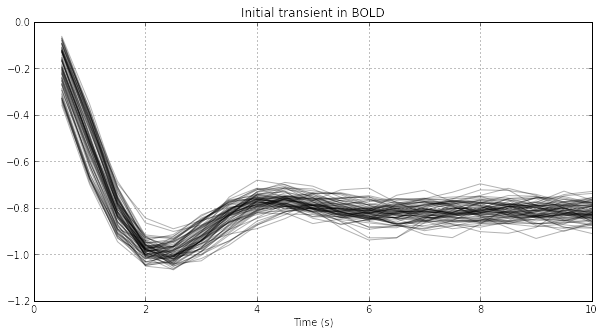

In [6]:
figure(figsize=(10, 5))
plot(bold_time * 1e-3, bold_data[:, 0, :, 0], 'k', alpha=0.3)
title('Initial transient in BOLD')
xlabel('Time (s)')
grid(True);

To save the state of the simulator, we need to put a few arrays into files:

In [10]:
sim_state_fname = 'sim_state.pickle'

with open(sim_state_fname, 'wb') as file_descr:
    cPickle.dump({
        'history': sim.history.buffer,
        'current_step': sim.current_step,
        'current_state': sim.current_state,
        'bold_inner': sim.monitors[1]._interim_stock,
        'bold': sim.monitors[1]._stock,
        'rng': sim.integrator.noise.random_stream.get_state()
    }, file_descr)

The simulation state is now saved in the current folder:

In [12]:
!ls -lh sim_state.pickle

-rw-r--r-- 1 mw mw 12M Jun  2 11:39 sim_state.pickle


We are free to dispose of the simulator:

In [16]:
del sim

## Continuing the simulation

Now we want to continue the simulator above with the saved state. In different scenarios, this might be in a different script, on a different day, so we need to build the simulator object again:

In [17]:
sim = simulator.Simulator(
    model=models.Generic2dOscillator(), 
    connectivity=connectivity.Connectivity(load_default=True),                      
    coupling=coupling.Linear(a=0.0126),
    simulation_length=1e4,
    integrator=integrators.HeunStochastic(
        dt=2 ** -4,
        noise=noise.Additive(nsig=array([0.001]))),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500.0),
        monitors.ProgressLogger(period=1e3)
    )
).configure()

2016-06-02 11:43:20,620 - INFO - tvb.simulator.models.base - Generic2dOscillator(**kwargs): initing...
2016-06-02 11:43:20,655 - WARNING - tvb.basic.readers - File hemispheres not found in ZIP.
2016-06-02 11:43:20,691 - INFO - tvb.simulator.noise - Additive(ntau, random_stream, nsig): initing...
2016-06-02 11:43:20,693 - INFO - tvb.simulator.integrators - HeunStochastic(dt, clamped_state_variable_indices, clamped_state_variable_values, noise): initing...
2016-06-02 11:43:20,694 - INFO - tvb.simulator.integrators - HeunStochastic(dt, clamped_state_variable_indices, clamped_state_variable_values, noise): initing...
2016-06-02 11:43:20,697 - INFO - tvb.simulator.monitors - TemporalAverage(pre_expr, post_expr, period, variables_of_interest): initing...
2016-06-02 11:43:20,718 - ERROR - tvb.simulator.simulator - hist_shape is (818.59061333333329, 2, 76, 1)
2016-06-02 11:43:20,719 - INFO - tvb.simulator.simulator - Memory requirement guesstimate: simulation will need about 31.9 MB
2016-06-02

load its state,

In [18]:
with open(sim_state_fname, 'rb') as file_descr:
    state = cPickle.load(file_descr)

sim.history.buffer = state['history']
sim.current_step = state['current_step']
sim.current_state = state['current_state']
sim.monitors[1]._interim_stock = state['bold_inner']
sim.monitors[1]._stock = state['bold']
sim.integrator.noise.random_stream.set_state(state['rng'])

and run it again; note that the step and time start off where the old simulator stopped:

In [19]:
(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

2016-06-02 11:45:48,331 - INFO - tvb.simulator.simulator - Simulation single-threaded runtime should be about 159 seconds!
2016-06-02 11:45:48,334 - INFO - tvb.simulator.simulator - Calculating storage requirement for ...
2016-06-02 11:45:48,336 - INFO - tvb.simulator.simulator - Calculated storage requirement for simulation: 13721040 
2016-06-02 11:45:48,341 - INFO - Sim Progress - step 160000 time 10.0000 s
2016-06-02 11:45:59,252 - INFO - Sim Progress - step 176000 time 11.0000 s
2016-06-02 11:46:10,234 - INFO - Sim Progress - step 192000 time 12.0000 s
2016-06-02 11:46:21,202 - INFO - Sim Progress - step 208000 time 13.0000 s
2016-06-02 11:46:32,068 - INFO - Sim Progress - step 224000 time 14.0000 s
2016-06-02 11:46:42,883 - INFO - Sim Progress - step 240000 time 15.0000 s
2016-06-02 11:46:53,443 - INFO - Sim Progress - step 256000 time 16.0000 s
2016-06-02 11:47:03,998 - INFO - Sim Progress - step 272000 time 17.0000 s
2016-06-02 11:47:15,430 - INFO - Sim Progress - step 288000 ti

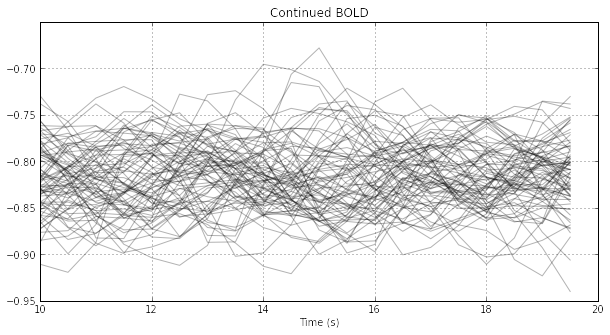

In [20]:
figure(figsize=(10, 5))
plot(bold_time * 1e-3, bold_data[:, 0, :, 0], 'k', alpha=0.3)
title('Continued BOLD')
xlabel('Time (s)')
grid(True);

The continued BOLD does not show the transient present in the initial simulation.